In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import xarray as xr
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from joblib import parallel_backend

from woodland_tuning_plots import *
from dataset_rejigging_funcs import *
from random_forest_running_funcs import *

plt.ion()


#====================

# Read in the datasets, NB xr.open_dataset is a pointer to the data
# get the subsets:
# UKCEH - area
# S2 bands 2-8, 11, 12
# TODO -  start with 1 season but move on to all 4 

ukceh_data = xr.open_dataset("data/ukregion-northeastengland.tif",engine="rasterio")
s2_data = xr.open_dataset("data/2020_Jan_Mar-0000000000-0000000000.tif",engine="rasterio")

# get the edge co-ords of the grids of the 2 datasets. 
ukceh_corners = get_corners(ukceh_data)
s2_corners = get_corners(s2_data)


2023-10-17 14:40:35.808154: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 14:40:35.907545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 14:40:35.908518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:40:37.246183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# flatten the datasets

s2_dims,s2_flat = select_bands_areas(s2_data,s2_corners,[2,3,4,5,6,7,8,11,12])
ukceh_dims, ukceh_flat = select_bands_areas(ukceh_data,s2_corners,[1])



In [3]:
# DESTRUCTIVE !!
# remove the nan from the data, now the dims are nonsense.

s2_flat = np.squeeze(s2_flat[:,np.argwhere(np.isnan(ukceh_flat)[0,:]==False)])
ukceh_flat = ukceh_flat[(np.isnan(ukceh_flat)==False)] # ukceh_flat[ukceh_flat>0]
ukceh_flat = ukceh_flat.astype("int8")
s2_flat[np.isnan(s2_flat)] = 0.



In [4]:
# normalise the data 
s2_flat = s2_flat - np.tile(s2_flat.mean(axis=1),[s2_flat.shape[1],1]).T
s2_flat /= np.tile(s2_flat.std(axis=1),[s2_flat.shape[1],1]).T

In [5]:
#================
# train test/split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(s2_flat.T, ukceh_flat, test_size=0.33, random_state=42)

In [6]:
from sklearn import svm

In [7]:
clf = svm.LinearSVC(dual="auto")

test set accuracy 0.5922
correctly classified woodland 0.7559
incorrectly classified as woodland 0.3346


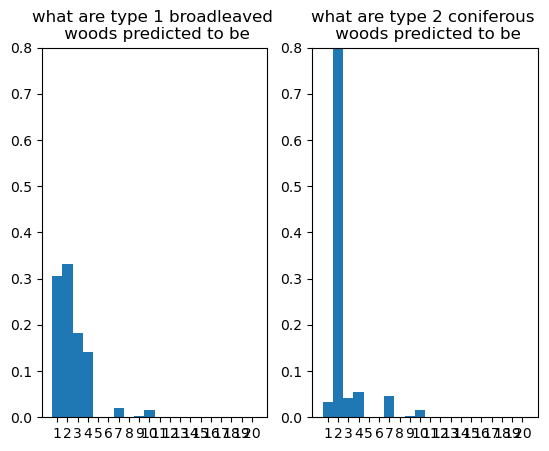

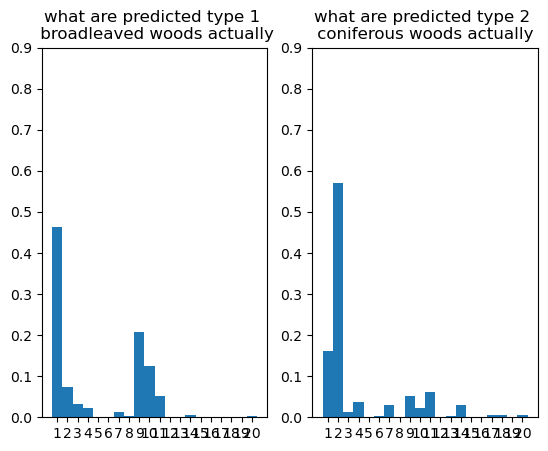

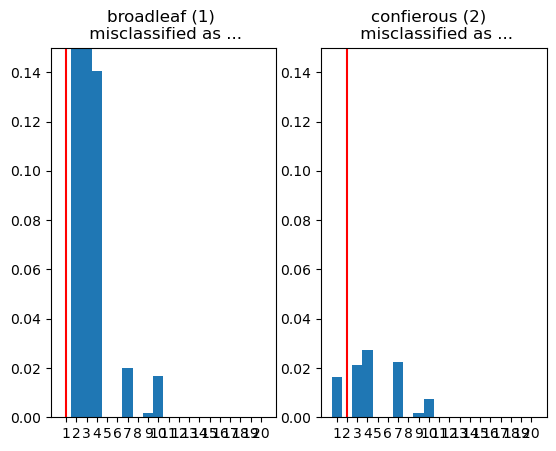

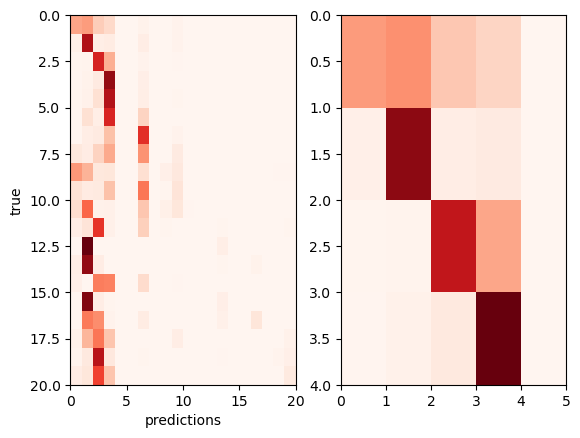

In [8]:
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

test set accuracy 0.5922
correctly classified woodland 0.7559
incorrectly classified as woodland 0.3345


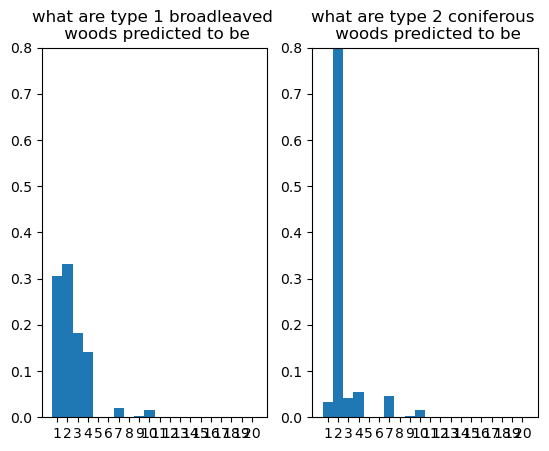

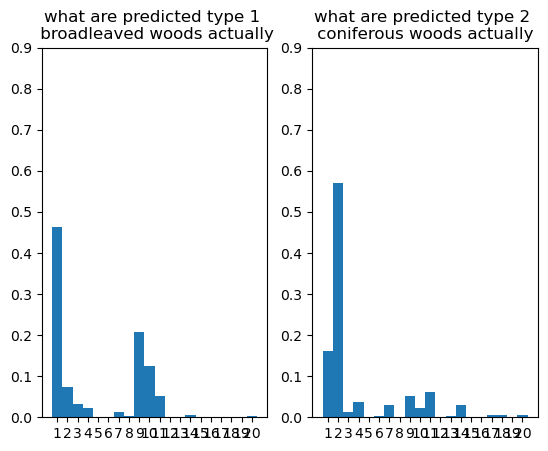

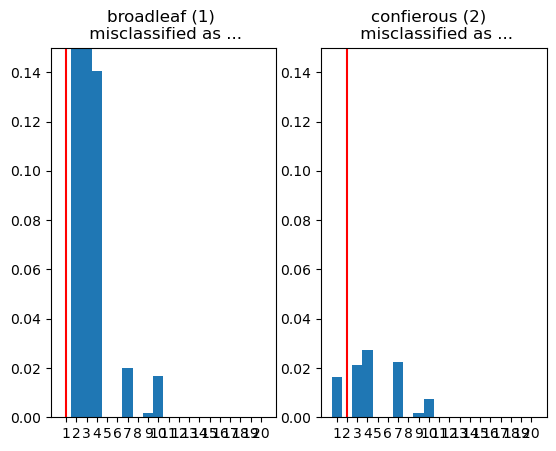

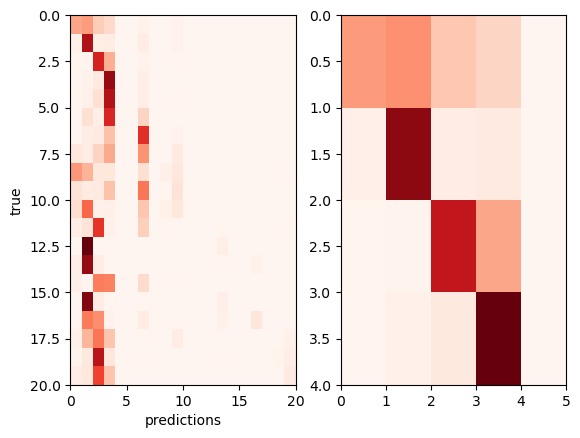

In [9]:
clf = svm.LinearSVC(dual="auto",C=10)
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

Linear kernel rubbish especially for broad leaves.
We'll try other kernels, but need to redo the SVC as one v rest explicitly 
SVC is unacceptably slow

test set accuracy 0.5523
correctly classified woodland 0.6579
incorrectly classified as woodland 0.3010


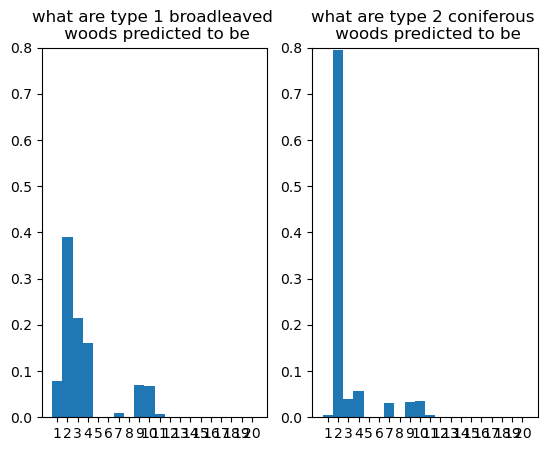

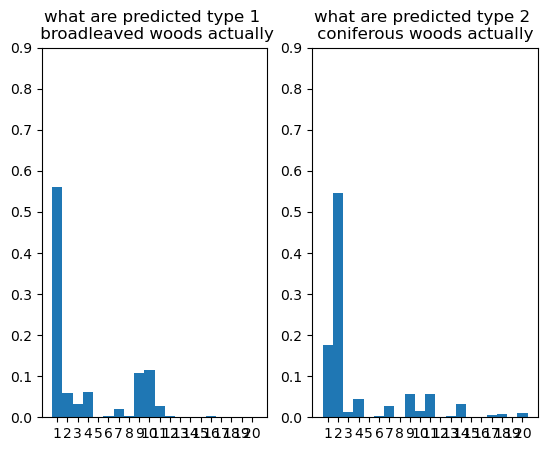

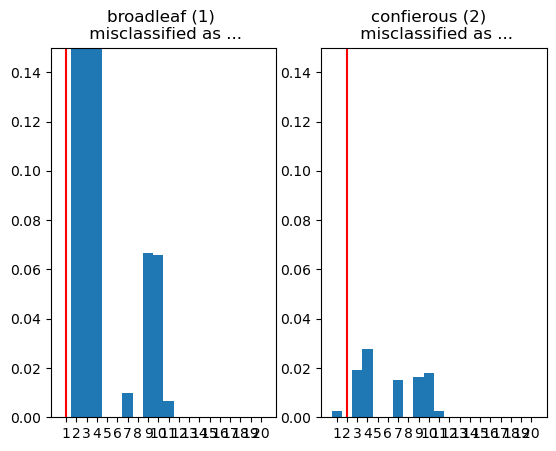

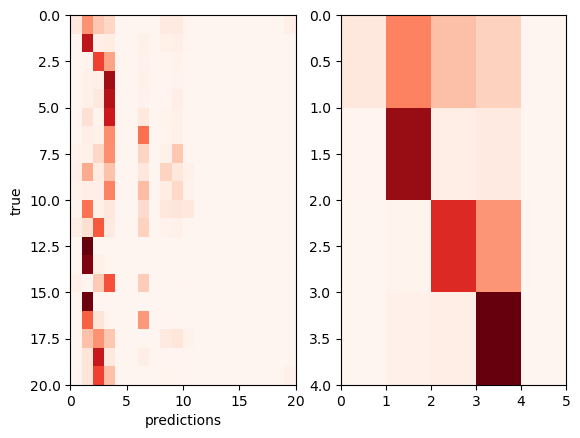

In [15]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

Linear SVM is rubbish, no surprise. Use a kernel, but can't use SVC as it's too slow

In [16]:
# apply kernel approx and re train/test split

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(rbf_feature.fit_transform(s2_flat.T), ukceh_flat, test_size=0.33, random_state=42)

In [17]:
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

test set accuracy 0.5538
correctly classified woodland 0.6863
incorrectly classified as woodland 0.2851


test set accuracy 0.5428
correctly classified woodland 0.7248
incorrectly classified as woodland 0.3250


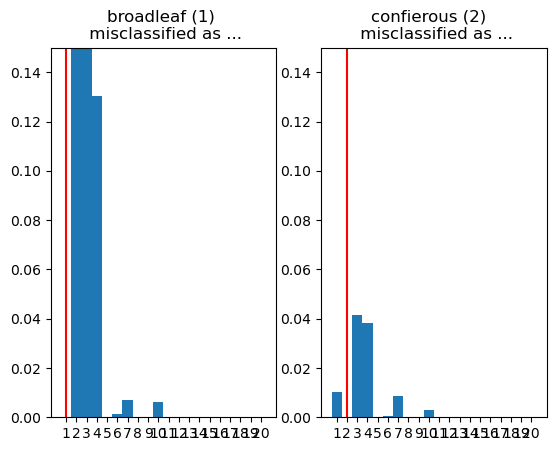

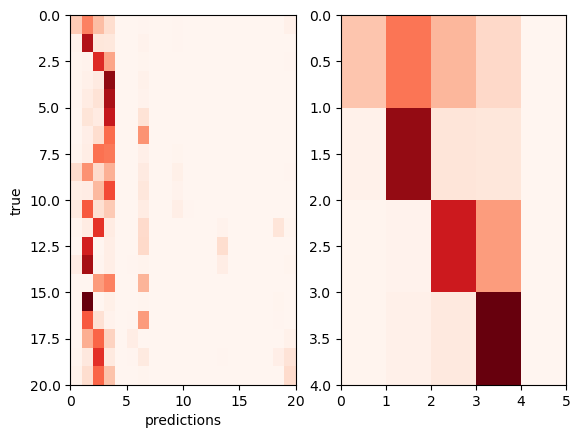

In [21]:
# apply kernel approx and re train/test split

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=.1, random_state=1,n_components=100)
X_train, X_test, y_train, y_test = train_test_split(rbf_feature.fit_transform(s2_flat.T), ukceh_flat, test_size=0.33, random_state=42)
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

test set accuracy 0.5517
correctly classified woodland 0.7204
incorrectly classified as woodland 0.3082


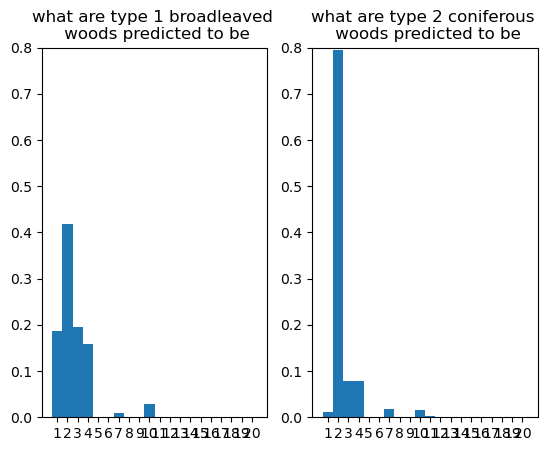

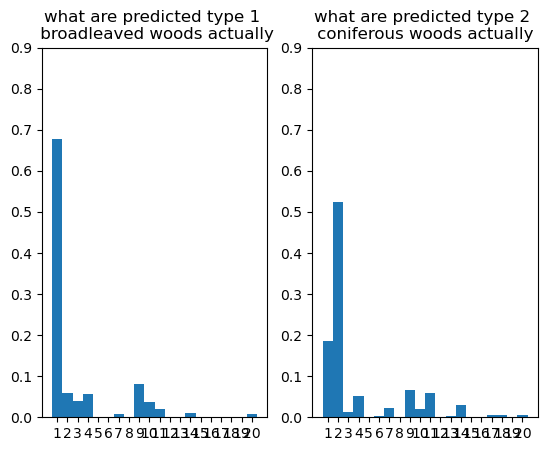

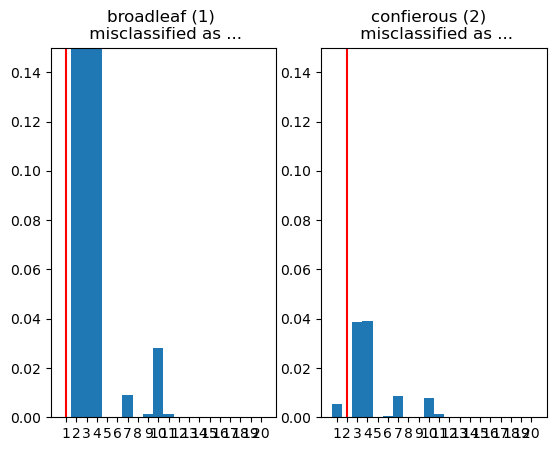

In [22]:
# apply kernel approx and re train/test split

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=.1, random_state=1,n_components=500)
X_train, X_test, y_train, y_test = train_test_split(rbf_feature.fit_transform(s2_flat.T), ukceh_flat, test_size=0.33, random_state=42)
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

test set accuracy 0.5722
correctly classified woodland 0.7231
incorrectly classified as woodland 0.2697


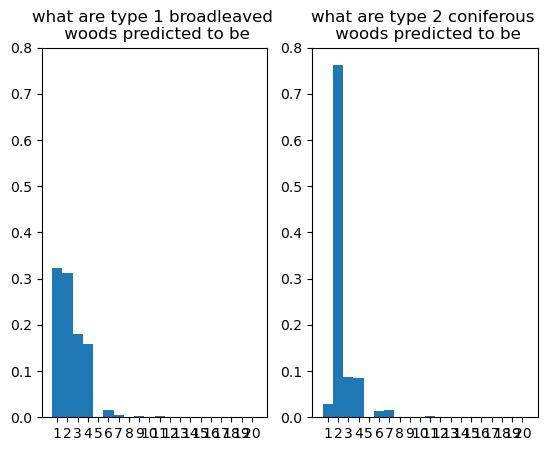

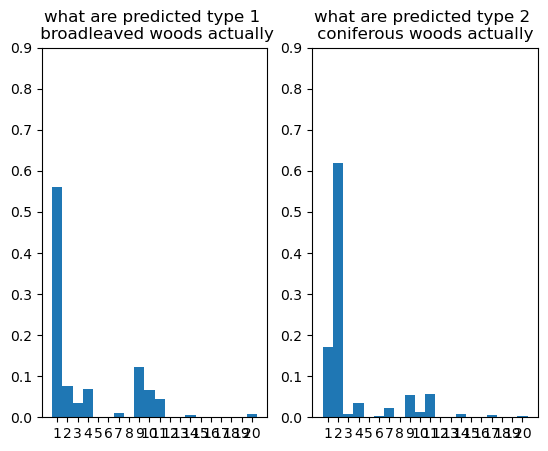

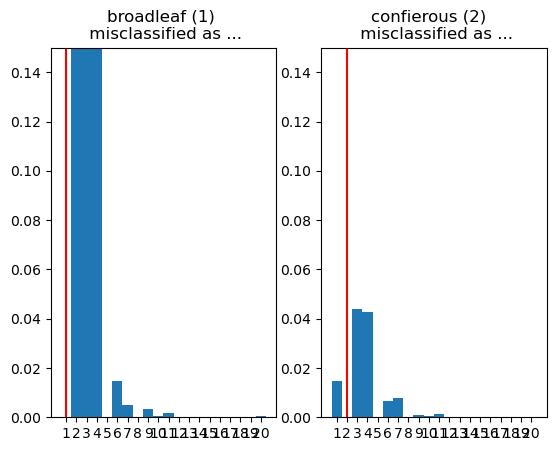

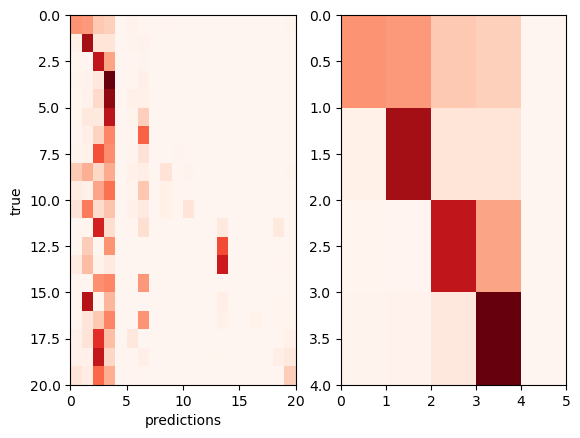

In [23]:
# apply kernel approx and re train/test split

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=.5, random_state=1,n_components=500)
X_train, X_test, y_train, y_test = train_test_split(rbf_feature.fit_transform(s2_flat.T), ukceh_flat, test_size=0.33, random_state=42)
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)

test set accuracy 0.5350
correctly classified woodland 0.7251
incorrectly classified as woodland 0.3081


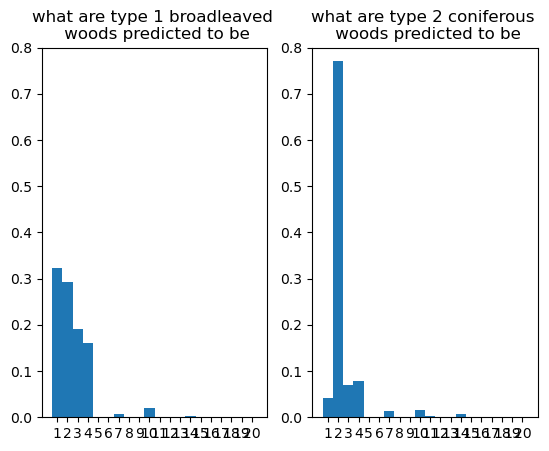

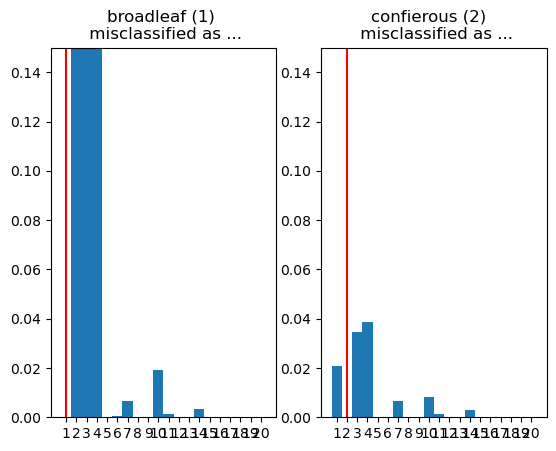

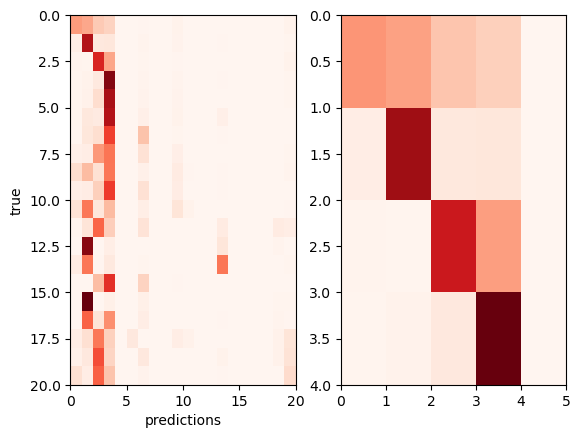

In [24]:
# apply kernel approx and re train/test split

from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=.5, random_state=1,n_components=50)
X_train, X_test, y_train, y_test = train_test_split(rbf_feature.fit_transform(s2_flat.T), ukceh_flat, test_size=0.33, random_state=42)
clf = SGDClassifier(n_jobs=-1, alpha=0.01,loss='hinge')
y_pred = run_model(clf,X_train,y_train,X_test,y_test)
woodland_plots(y_pred,y_test)
miscat_plots(y_pred,y_test)
confusion_plots(y_pred,y_test)